# Object-based filtering of pixel classifications


## Background

Geographic Object-Based Image Analysis (GEOBIA), aims to group pixels together into meaningful image-objects. There are two advantages to a GEOBIA workflow: one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but more meaningful objects. A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description

In this notebook, we take the pixel-based classifications generated in the `4_Classify_satellite_data.ipynb` notebook, and filter the classifications by image-objects. To do this, we first need to conduct image segmentation using the function `skimage.segmentation.quickshift`. The image segmentation is conducted on the `NDVI` layer output in the previous notebook.
To filter the pixel observations, we assign to each segment the majority (mode) pixel classification using the `scipy.ndimage.measurements import _stats` module. 

1. Run the image segmentation
2. Visualize the segments 
2. Calculate the **mode** statistic for each segment
3. Write the new object-based classification to disk as a COG
4. Plot the result

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import scipy
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from scipy.ndimage._measurements import _stats
from skimage.segmentation import quickshift
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap

## Analysis Parameters

* The `year` and `output_dir` are copied from the `1_Extract_training_data.ipynb` notebook.
* `pred_tif`: The path and name of the prediction GeoTIFF output from the previous notebook.
* `tif_to_seg`: The geotiff to use as an input to the image segmentation, in the default example this was an NDVI layer output from  the last notebook.


In [2]:
year = "2017"
output_dir = "results"

pred_tif = f"{output_dir}/prediction_{year}.tif"

tif_to_seg = f"{output_dir}/NDVI.tif_{year}.tif"

In [3]:
# Below are variables to be used when plotting the prediction images. 
labels = {1: {'color': '#F096FF', 'flag': 'Cropland'},
 2: {'color': '#007800', 'flag': 'Dense Forest'},
 3: {'color': '#648C00', 'flag': 'Open Forest'},
 4: {'color': '#FFBB22', 'flag': 'Open Grassland'},
 5: {'color': '#0032C8', 'flag': 'Open Water'},
 6: {'color': '#B4B4B4', 'flag': 'Otherland'},
 7: {'color': '#FA0000', 'flag': 'Settlements'},
 8: {'color': '#0096A0', 'flag': 'Vegetated Wetland'},
 9: {'color': '#FFFF4C', 'flag': 'Wooded Grassland'}}

colors = [label['color'] for label in labels.values()]
cmap = ListedColormap([label['color'] for label in labels.values()])
norm = mcolors.BoundaryNorm(list(labels.keys())+[221], cmap.N+1, extend='max')
ticks = list(np.mean((list(list(labels.keys())+[221])[i+1], val)) for i, val in enumerate(list(labels.keys())))
cblabels=[label['flag'] for label in labels.values()]

## Generate an object-based classification

In [4]:
# Open the NDVI image.
ndvi = rio.open_rasterio(tif_to_seg).squeeze().drop_vars('band')
# Open pixel-based predictions.
pred = rio.open_rasterio(pred_tif).squeeze().drop_vars('band')

In [5]:
# Convert our mean NDVI xarray.DataArray into a numpy array.
ndvi_np = ndvi.values
# Convert our prediction xarray.DataArray into a numpy array.
pred_np = pred.values

### Run image segmentation

In [6]:
%%time
# Using the function quickshift from the scikit-image, 
# we will conduct an image segmentation on the mean NDVI numpy array to calculate the segments.
segments = quickshift(ndvi_np,
                      kernel_size=2,
                      convert2lab=False,
                      max_dist=4,
                      ratio=1.0)

CPU times: user 1min 36s, sys: 1.29 s, total: 1min 37s
Wall time: 1min 37s


### Visualise segments

To help us visualize the segments, we can calculate the zonal mean NDVI for each segment and then we'll plot a zoomed in section of the region.

In [7]:
# Calculate a zonal mean NDVI across each segment using the 
# input mean NDVI numpy array.
segments_zonal_mean_qs = scipy.ndimage.mean(input=ndvi_np,
                                            labels=segments,
                                            index=segments)

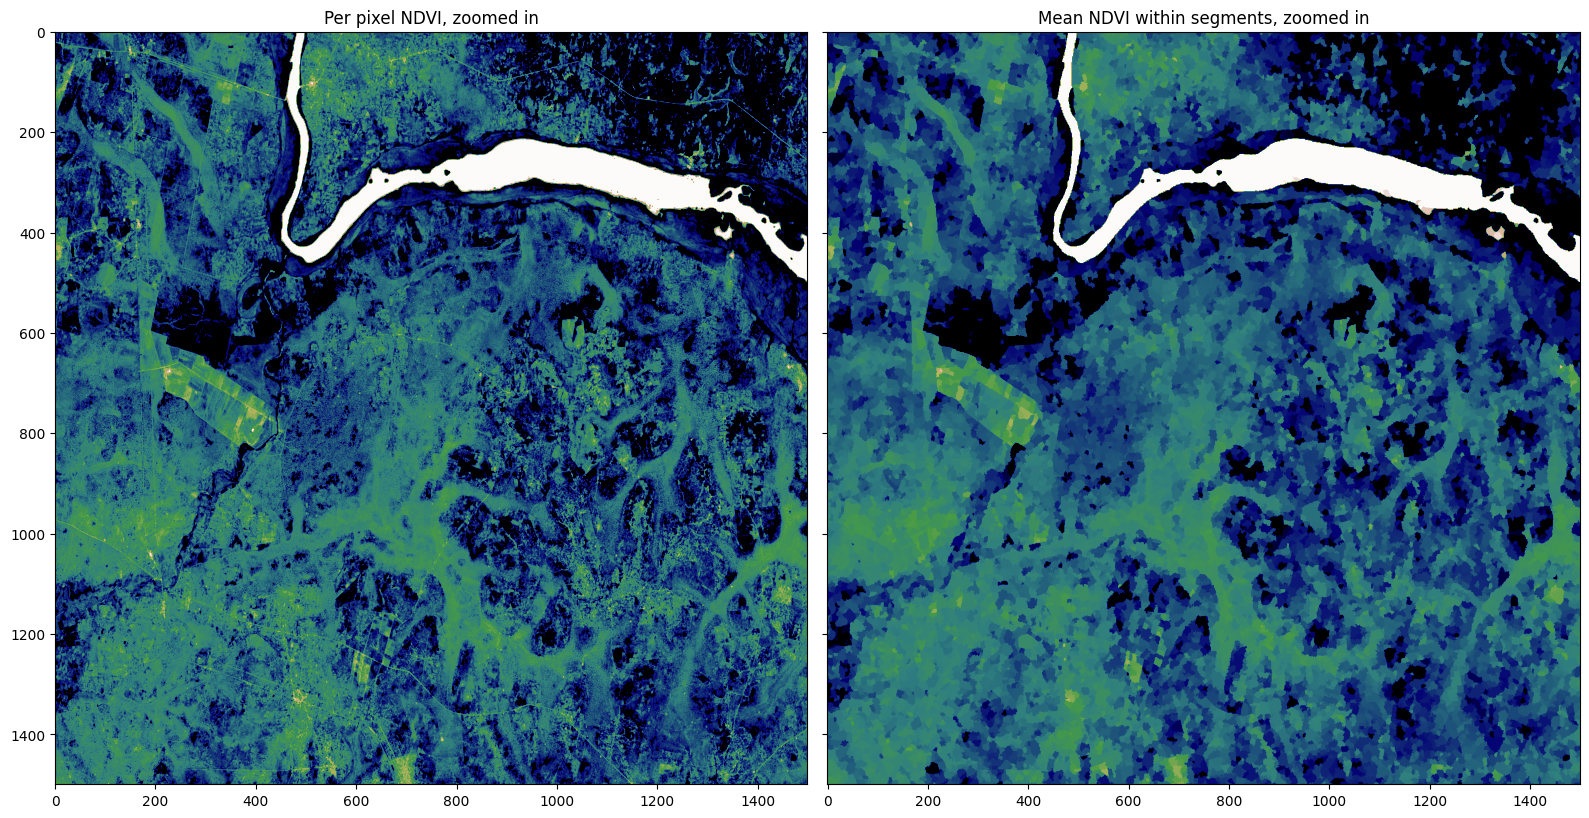

In [8]:
# To help us visualize the segments, we'll plot a zoomed in section of the region.
fig,ax=plt.subplots(1,2, figsize=(16,8), sharey=True)
ax[0].imshow(ndvi_np[1000:2500,1000:2500], cmap='gist_earth_r', vmin=0.1, vmax=0.7)
ax[1].imshow(segments_zonal_mean_qs[1000:2500,1000:2500], cmap='gist_earth_r', vmin=0.1, vmax=0.7)
ax[0].set_title('Per pixel NDVI, zoomed in');
ax[1].set_title('Mean NDVI within segments, zoomed in')
plt.tight_layout();

### Apply the image segmentation to the prediction image

Within each segment, the majority classification is calculated and assigned to that segment.

In [9]:
%%time
# For each unique segment, get the class value that occurs the most in the prediction image. 
index = np.unique(segments)

def get_mode(val):
    val_mode = scipy.stats.mode(val,axis=0, nan_policy='propagate', keepdims=True)[0][0]
    return val_mode

new_labels = scipy.ndimage.labeled_comprehension(input=pred_np, 
                                                 labels=segments,
                                                 index=index,
                                                 func=get_mode,
                                                 out_dtype=float,
                                                 default=0)

# Create a dictionary mapping each unique segment to its modal class value.
new_label_dict = dict(zip(index, new_labels))

# Within each segment, assign the majority/modal classification that occurs in 
# the prediction image to that segment.
sort_idx = np.argsort(list(new_label_dict.keys()))
idx = np.searchsorted(list(new_label_dict.keys()), segments, sorter = sort_idx)
pred_segmented_np = np.asarray(list(new_label_dict.values()))[sort_idx][idx]


# Convert the segmented prediction image numpy array to a xarray.DataArray.
pred_segmented = xr.DataArray(pred_segmented_np,  coords=pred.coords, dims=pred.dims, attrs=pred.attrs).astype(np.int16)

CPU times: user 26 s, sys: 404 ms, total: 26.4 s
Wall time: 26.4 s


## Plot result

Below we plot the the pixel-based classification alongside the newly created object-based classification. You can see the 'salt and pepper' effect of individual pixels being classified has been removed in the object based classification, resulting in a 'cleaner' classification.

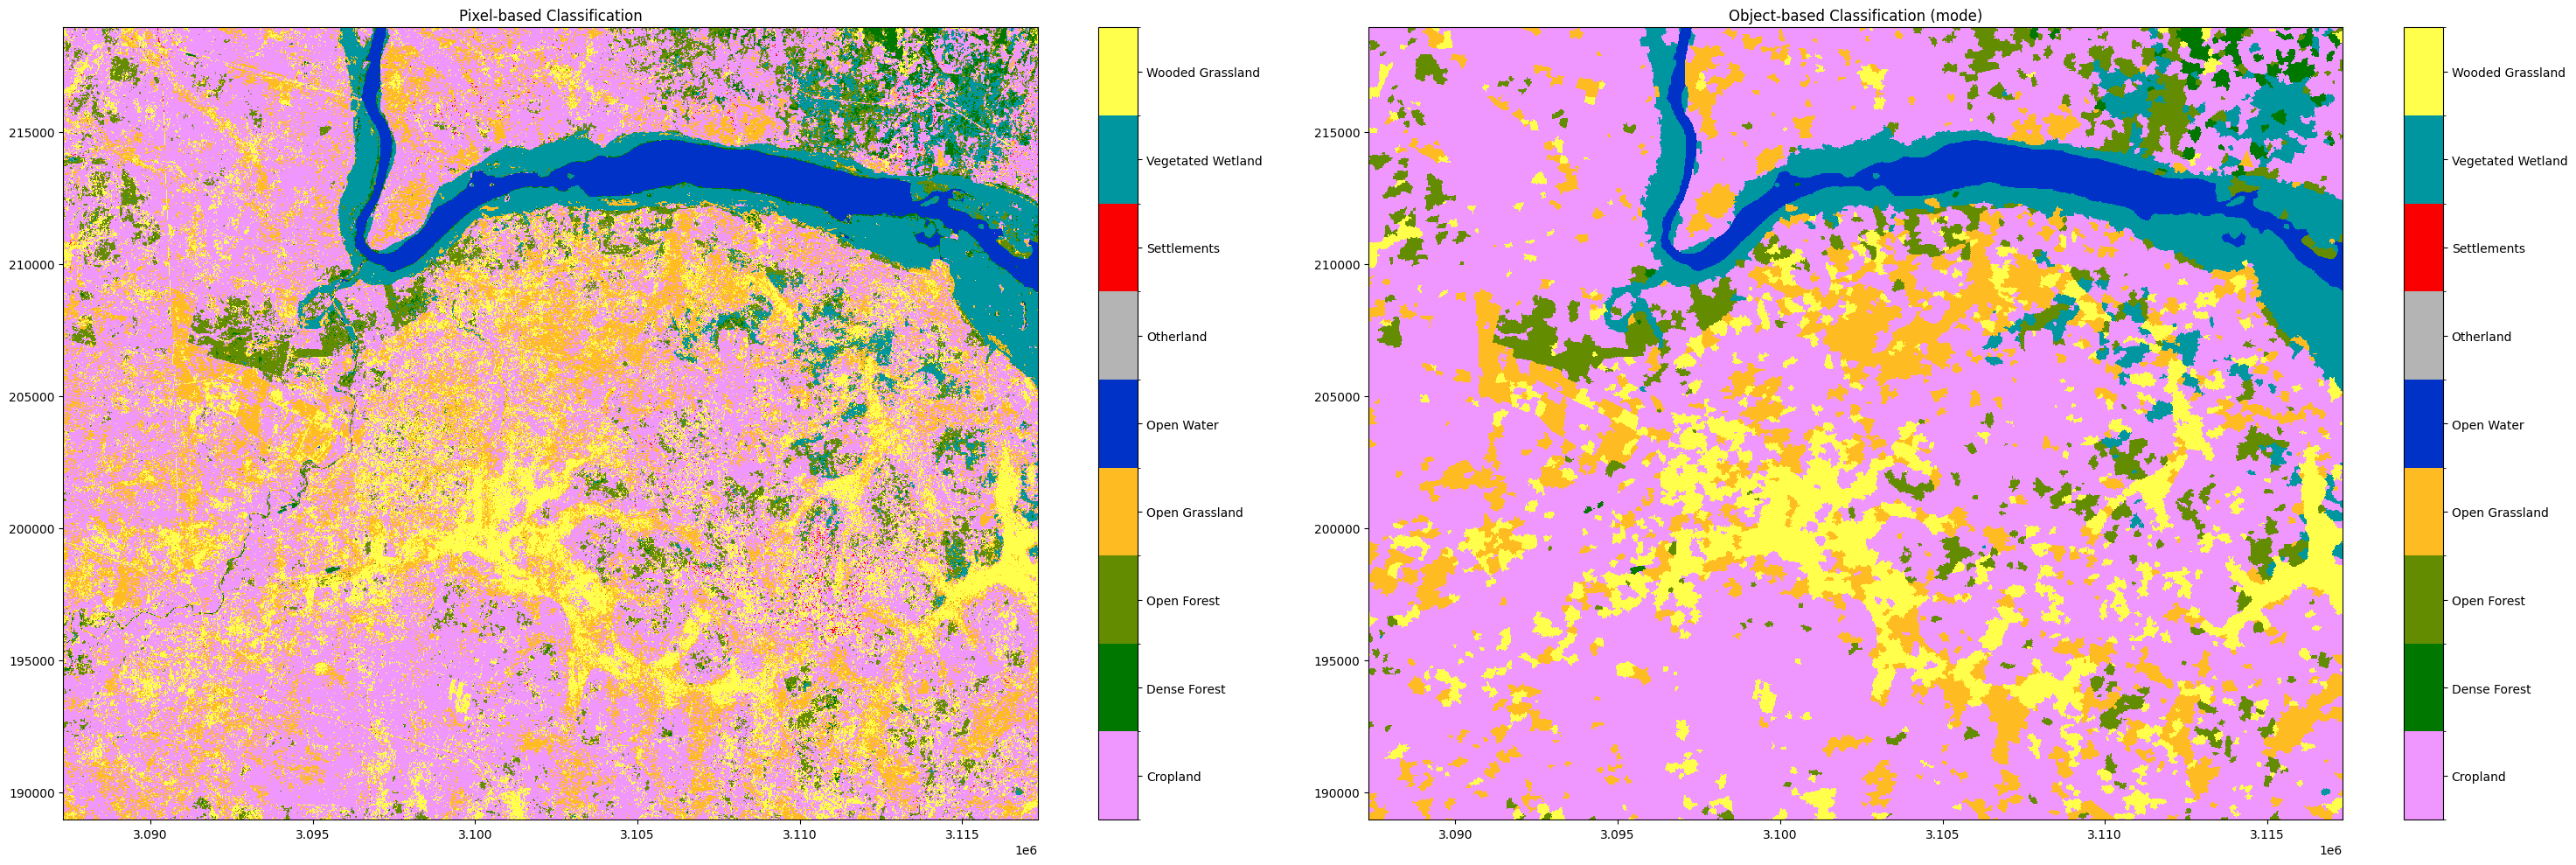

In [10]:
# Let's plot a zoomed in section of the region of the two prediction images. 
# You can see the 'salt and pepper' effect of individual pixels being classified 
# has been removed in the object based classification, resulting in a 'cleaner' classification. 
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

# Plot the per-pixel classified image.
im = pred[1000:2500,1000:2500].plot.imshow(ax=axes[0], 
               cmap=cmap,
               norm=norm,
               add_labels=False, 
               add_colorbar=True)
cb = im.colorbar
cb.set_ticks(ticks)
cb.set_ticklabels(cblabels)

    
# Plot object-based classified image.
im1 = pred_segmented[1000:2500,1000:2500].plot.imshow(ax=axes[1], 
               cmap=cmap,
               norm=norm,
               add_labels=False, 
               add_colorbar=True)
cb1 = im1.colorbar
cb1.set_ticks(ticks)
cb1.set_ticklabels(cblabels)

# Add plot titles.
axes[0].set_title('Pixel-based Classification')
axes[1].set_title('Object-based Classification (mode)')
plt.tight_layout();

## Write result to disk

In [11]:
# Write the results to disk. 
write_cog(pred_segmented, f'{output_dir}/prediction_object_{year}.tif', overwrite=True)

PosixPath('results/prediction_object_2017.tif')

## Recommended next steps

This is the last notebook in the `Scalable Machine Learning on the ODC` workflow! To revist any of the other notebooks, use the links below.

1. [Extracting_training_data](1_Extract_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. [Evaluate_optimize_fit_classifier](3_Evaluate_optimize_fit_classifier.ipynb)
4. [Classify_satellite_data](4_Classify_satellite_data.ipynb)
5. **Object-based_filtering (this notebook)**


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).


**Last Tested:**

In [12]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-11-08'